## Spooky Author Identification

The competition dataset contains text from works of fiction written by spooky authors of the public domain: Edgar Allan Poe, HP Lovecraft and Mary Shelley. The data was prepared by chunking larger texts into sentences using CoreNLP's MaxEnt sentence tokenizer, so you may notice the odd non-sentence here and there. Your objective is to accurately identify the author of the sentences in the test set.

#### Data fields
* id - a unique identifier for each sentence
* text - some text written by one of the authors
* author - the author of the sentence (EAP: Edgar Allan Poe, HPL: HP Lovecraft; MWS: Mary Wollstonecraft Shelley)

You can also find the dataset <a href = "https://www.kaggle.com/competitions/spooky-author-identification/overview"> here</a>

***

### Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras import layers
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

### Read 'spooky.csv' dataset

In [2]:
df=pd.read_csv( 'spooky.csv' )

In [3]:
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


### Drop 'id' column

In [4]:
df.drop(columns=['id'],inplace=True)

In [5]:
df

,text,author
0,"This process, however, afforded me no means of...",EAP
1,It never once occurred to me that the fumbling...,HPL
2,"In his left hand was a gold snuff box, from wh...",EAP
3,How lovely is spring As we looked from Windsor...,MWS
4,"Finding nothing else, not even gold, the Super...",HPL
...,...,...
19574,"I could have fancied, while I looked at it, th...",EAP
19575,The lids clenched themselves together as if in...,EAP
19576,"Mais il faut agir that is to say, a Frenchman ...",EAP
19577,"For an item of news like this, it strikes us i...",EAP


### Check for missing values

In [7]:
df.isna().sum()

text      0
author    0
dtype: int64

### Check for duplicates

In [9]:
df.duplicated().sum()

0

### Print some of the text along with its author

In [10]:
for i in range(5):
    print(df['text'][i],'-',df['author'][i])
    print()

This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall. - EAP

It never once occurred to me that the fumbling might be a mere mistake. - HPL

In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction. - EAP

How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair. - MWS

Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk. - HPL



### Create a function to preproces the text

In [11]:
def preprocess(sentence):
    text = re.sub(r"[^a-zA-Z0-9]"," ",sentence).split()
    
    words = [x.lower() for x in text if x not in stopwords.words('english')]
    
    lemma = WordNetLemmatizer()
    word = [lemma.lemmatize(word,'v') for word in words ]
    
    word = ' '.join(word)
    return word

In [12]:
df['text']=df['text'].apply(preprocess)

### Print some of the text after preprocess

In [13]:
for i in range(5):
    print(df['text'][i],'-',df['author'][i])
    print()

this process however afford mean ascertain dimension dungeon i might make circuit return point whence i set without aware fact perfectly uniform seem wall - EAP

it never occur fumble might mere mistake - HPL

in leave hand gold snuff box caper hill cut manner fantastic step take snuff incessantly air greatest possible self satisfaction - EAP

how lovely spring as look windsor terrace sixteen fertile counties spread beneath speckle happy cottages wealthier towns look former years heart cheer fair - MWS

find nothing else even gold superintendent abandon attempt perplex look occasionally steal countenance sit think desk - HPL



### Check for imbalance in the dataset

<Axes: ylabel='author'>

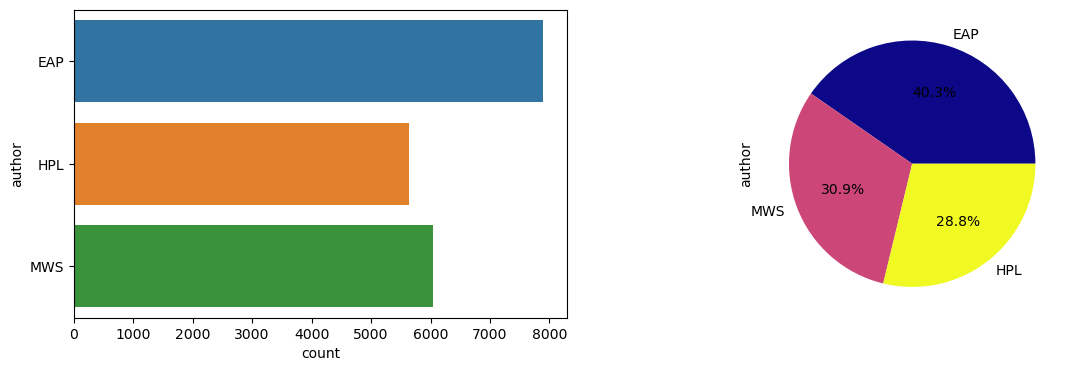

In [20]:
plt.figure(figsize= (14,4))
plt.subplot(1,2,1)
sns.countplot(y = df['author'])
plt.subplot(1,2,2)
df['author'].value_counts().plot.pie(autopct = '%1.1f%%', cmap = 'plasma')

### Split the dataset into Input & Target Variables

In [21]:
X=df['text']
y=df['author']

### Label Encode our target variables

In [23]:
y=y.map({'EAP':0,'HPL':1,'MWS':2})

In [25]:
y

0        0
1        1
2        0
3        2
4        1
        ..
19574    0
19575    0
19576    0
19577    0
19578    1
Name: author, Length: 19579, dtype: int64

### Create Keras tokenizer object with 5000 max words
* Convert text to sequence
* Add padding

In [26]:
tokenizer=Tokenizer(num_words=5000)

In [27]:
tokenizer.fit_on_texts(X)

In [28]:
vocab_size=len(tokenizer.word_index)+1

In [30]:
def text_encoding(txt):
    encoded_docs=tokenizer.texts_to_sequences(txt)
    padded_sequence=pad_sequences(encoded_docs,maxlen=128)
    
    return padded_sequence
X = text_encoding(X)

### Split the dataset into Training & Testing set

In [31]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

### Create keras Sequential model with GRU layers

In [46]:
model = Sequential()

model.add(layers.Embedding(vocab_size, 128))

model.add(layers.GRU(128,  return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.GRU(128))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(3, activation='softmax'))

In [47]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 128)         2506368   
                                                                 
 gru_8 (GRU)                 (None, None, 128)         99072     
                                                                 
 dropout_6 (Dropout)         (None, None, 128)         0         
                                                                 
 gru_9 (GRU)                 (None, 128)               99072     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 3)                

### Compile the model

In [50]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

### Train the model

In [51]:
model.fit(X_train,y_train,epochs=10,validation_split=0.2)

Epoch 1/10
392/392 [==============================] - 114s 276ms/step - loss: 0.7191 - accuracy: 0.6853 - val_loss: 0.5178 - val_accuracy: 0.7814
Epoch 2/10
392/392 [==============================] - 104s 265ms/step - loss: 0.3825 - accuracy: 0.8506 - val_loss: 0.5105 - val_accuracy: 0.7913
Epoch 3/10
392/392 [==============================] - 103s 263ms/step - loss: 0.2711 - accuracy: 0.8962 - val_loss: 0.6178 - val_accuracy: 0.7868
Epoch 4/10
392/392 [==============================] - 102s 261ms/step - loss: 0.1893 - accuracy: 0.9302 - val_loss: 0.7053 - val_accuracy: 0.7801
Epoch 5/10
392/392 [==============================] - 102s 261ms/step - loss: 0.1282 - accuracy: 0.9523 - val_loss: 0.9173 - val_accuracy: 0.7667
Epoch 6/10
392/392 [==============================] - 103s 262ms/step - loss: 0.0925 - accuracy: 0.9666 - val_loss: 1.0052 - val_accuracy: 0.7644
Epoch 7/10
392/392 [==============================] - 102s 259ms/step - loss: 0.0776 - accuracy: 0.9705 - val_loss: 1.0510 -

### Make predictions with X_test

In [52]:
y_pred=model.predict(X_test)

123/123 [==============================] - 6s 29ms/step


### Fetch the index of the higher probable prediction

In [53]:
y_pred=[np.argmax(i) for i in y_pred]

### Evaluate the model

#### Accuracy score

In [55]:
accuracy_score(y_test,y_pred)

0.7594484167517875

#### Confusion matrix

<Axes: >

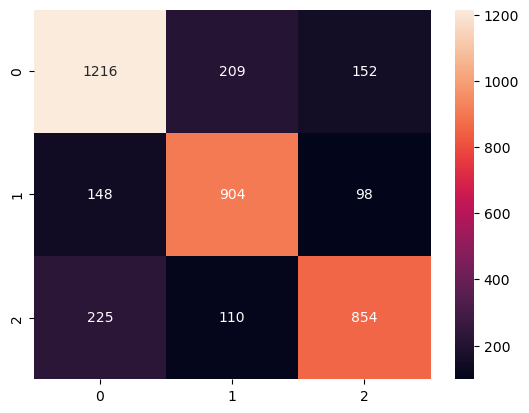

In [56]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot = True, fmt = 'd')

#### Classification Report

In [57]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1577
           1       0.74      0.79      0.76      1150
           2       0.77      0.72      0.74      1189

    accuracy                           0.76      3916
   macro avg       0.76      0.76      0.76      3916
weighted avg       0.76      0.76      0.76      3916



***